In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib widget
# %gui qt

import time
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from vrAnalysis import session
from vrAnalysis import functions
from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import fileManagement as fm
from vrAnalysis import database

from vrAnalysis.redgui import redCellGUI as rgui

In [6]:
# Immediate next steps for programming work:
# - ROICaT index alignment tools

In [2]:
mouseName = 'CR_Hippocannula6'
dateString = '2022-09-05'
sessionid = '701'
# vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.processTimeline()
# vrReg.processImaging()
# vrReg.processRedCells()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In [102]:
mouseName = 'ATL012'
dateString = '2023-02-01'
sessionid = '701'

# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [45]:
mouseName = 'ATL027'
dateString = '2023-08-01'
sessionid = '701'

# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [ ]:
# # vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.doPreprocessing()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In session: ATL020/2023-05-04/702, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
Computing red cell features for ATL020/2023-05-04/702... (usually takes 10-20 seconds)
Facecam preprocessing has not been coded yet!
C:\Users\andrew\Documents\localData\ATL020\2023-05-04\702


In [103]:
# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [10]:
%%time
speedThreshold = 5
omap, smap, lickmap, distvec = functions.getBehaviorMaps(vrexp,speedThreshold=speedThreshold) # produce smoothed occupancy and speed maps, along with the distance bins used to create them
frameTrialIdx, framePosition, frameSpeed = vrexp.getFrameBehavior() # convert behavioral data into timeframe of spiking data
spkmap = functions.getSpikeMap(vrexp, frameTrialIdx, framePosition, frameSpeed, distvec, omap, speedThreshold=speedThreshold, standardizeSpks=False, doSmoothing=0) # produce the spkmap 
idxFullTrials = np.all(~np.isnan(omap),axis=1) # find out which trials the mouse explored the whole environment
relmse, relcor = functions.measureReliability(spkmap[:,idxFullTrials], numcv=3) # measure reliability of spiking
spInfo = functions.measureSpatialInformation(omap[idxFullTrials], spkmap[:,idxFullTrials]) # measure spatial information of spiking

CPU times: total: 891 ms
Wall time: 542 ms


In [ ]:
# Code block for opening redSelectionGUI for a vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)
redCell = session.redCellProcessing(vrexp)
# redSelection = rgui.redSelectionGUI(redCell)

Cannot move to target thread (0x2703e0b4190)



In [50]:
vrreg.timelineInputs()

['timestamps',
 'chrono',
 'syncEcho',
 'photoDiode',
 'audioMonitor',
 'piezoCommand',
 'piezoPosition',
 'laserPower',
 'pockelsControl',
 'neuralFrames',
 'rewardCommand',
 'scanimageTrigger',
 'lickDetector',
 'rotaryEncoder',
 'camSync',
 'flipper']

In [56]:
vrreg = session.vrRegistration(vrexp)
vrreg.loadTimelineStructure()
ts = vrreg.getTimelineVar('timestamps')
piezo = vrreg.getTimelineVar('piezoPosition')
neuralFrames = vrreg.getTimelineVar('neuralFrames')

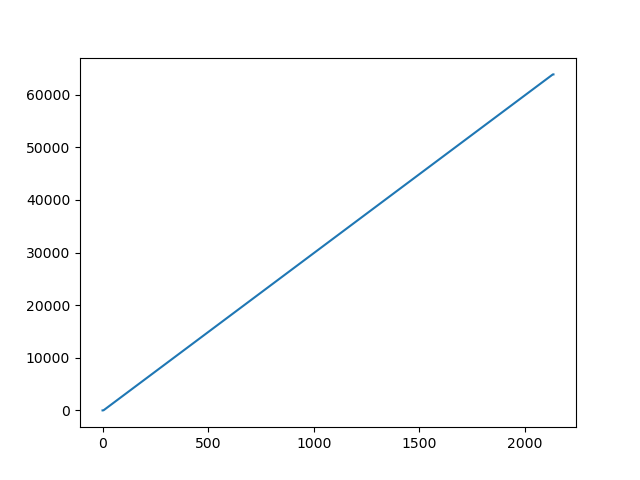

In [57]:
plt.close('all')
fig = plt.figure()
plt.plot(ts, neuralFrames)
plt.show()

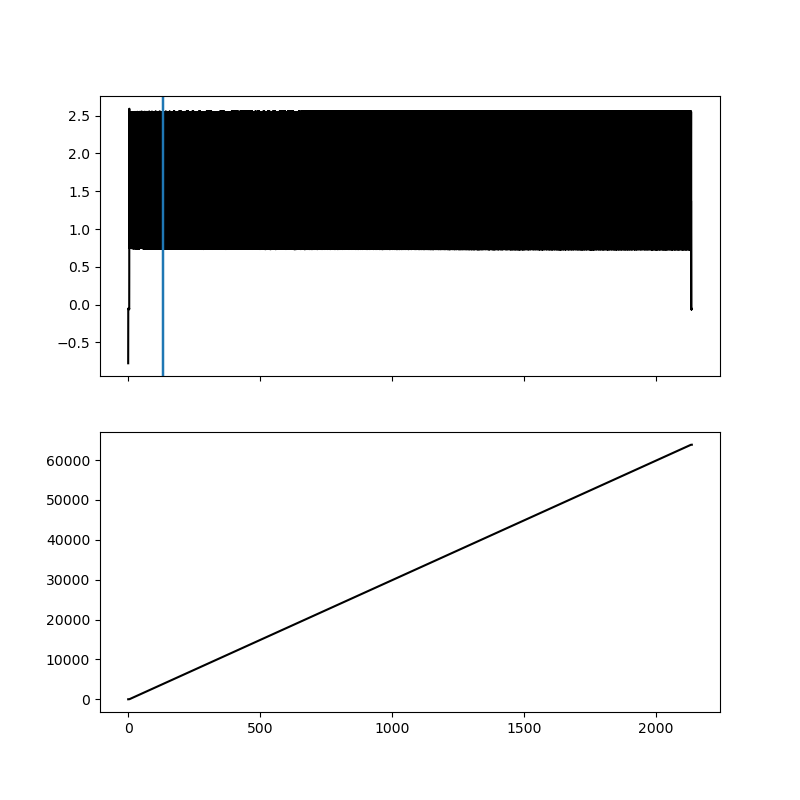

In [58]:
plt.close('all')

planes = np.linspace(130.839, 131.006, 6)

fig, ax = plt.subplots(2,1,sharex=True, figsize=(8,8))
ax[0].plot(ts, piezo, c='k')
# ax[0].xlim(130.82, 131.02)
for p in planes:
    ax[0].axvline(x=p)

ax[1].plot(ts, neuralFrames, c='k')

plt.show()

In [16]:
corrCutoff = 0.33

idxHigh = scc.xcPairs > corrCutoff
xcHigh = scc.xcPairs[idxHigh]
pp1High = scc.pp1[idxHigh]
pp2High = scc.pp2[idxHigh]
npix1High = scc.npx1[idxHigh]
npix2High = scc.npx2[idxHigh]

idx23 = (pp1High==2) & (pp2High==3)
idx34 = (pp1High==3) & (pp2High==4)
print(f"23 counts: {np.sum(idx23)}")
print(f"34 counts: {np.sum(idx34)}")

# Get counts of high correlation pairs for each plane-plane comparison
ppHighStr = [str(int(p1))+str(int(p2)) for (p1,p2) in zip(pp1High, pp2High)]
ppUniq, ppCounts = np.unique(ppHighStr, return_counts=True)

# Return npix/npix values for pairs within certain plane combos
xc_23 = xcHigh[idx23]
xc_34 = xcHigh[idx34]

npix1High_23 = npix1High[idx23]
npix2High_23 = npix2High[idx23]

npix1High_34 = npix1High[idx34]
npix2High_34 = npix2High[idx34]

23 counts: 2186
34 counts: 1840


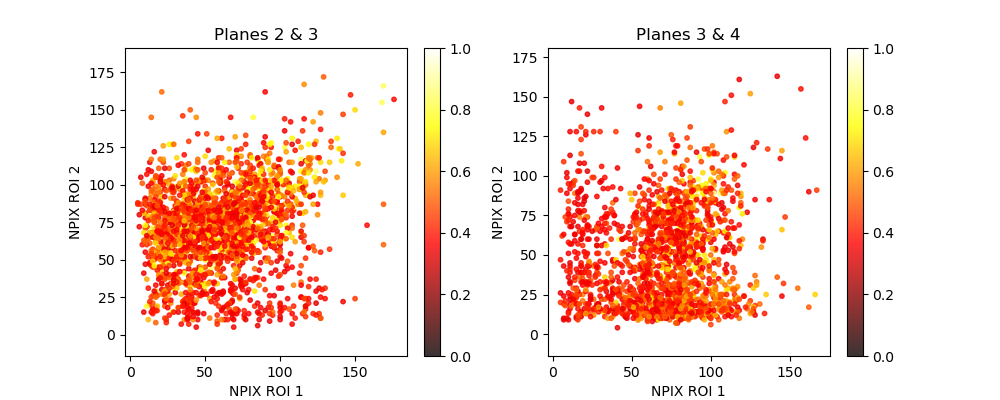

In [17]:
plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(10,4))
cax = ax[0].scatter(npix1High_23, npix2High_23, c=xc_23, s=10, alpha=0.8, cmap='hot', vmin=0, vmax=1)
ax[0].set_xlim(0,210)
ax[0].set_ylim(0,210)
cbar = fig.colorbar(cax)
ax[0].axis('equal')
ax[0].set_xlabel('NPIX ROI 1')
ax[0].set_ylabel('NPIX ROI 2')
ax[0].set_title('Planes 2 & 3')

cax = ax[1].scatter(npix1High_34, npix2High_34, c=xc_34, s=10, alpha=0.8, cmap='hot', vmin=0, vmax=1)
ax[1].set_xlim(0,210)
ax[1].set_ylim(0,210)
cbar = fig.colorbar(cax)
ax[1].axis('equal')
ax[1].set_xlabel('NPIX ROI 1')
ax[1].set_ylabel('NPIX ROI 2')
ax[1].set_title('Planes 3 & 4')

plt.show()

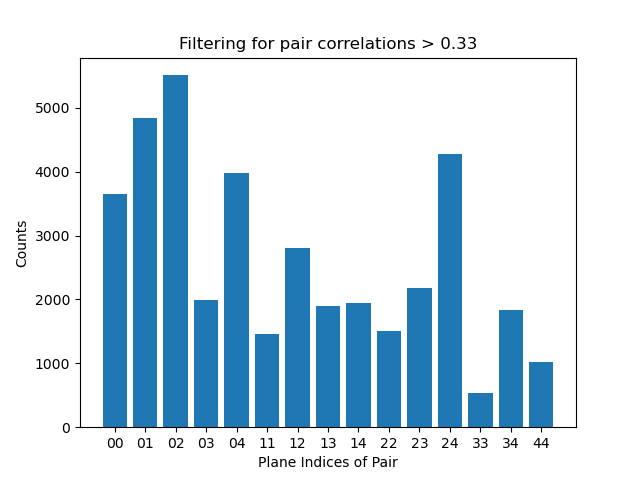

In [19]:
fig = plt.figure()
plt.bar(x=range(len(ppUniq)), height=ppCounts, tick_label=[str(int(pp)).zfill(2) for pp in ppUniq])
plt.xlabel('Plane Indices of Pair')
plt.ylabel('Counts')
plt.title(f'Filtering for pair correlations > {corrCutoff}')
plt.show()

In [10]:
vrexp.sessionPrint()

'ATL020/2023-03-24/701'

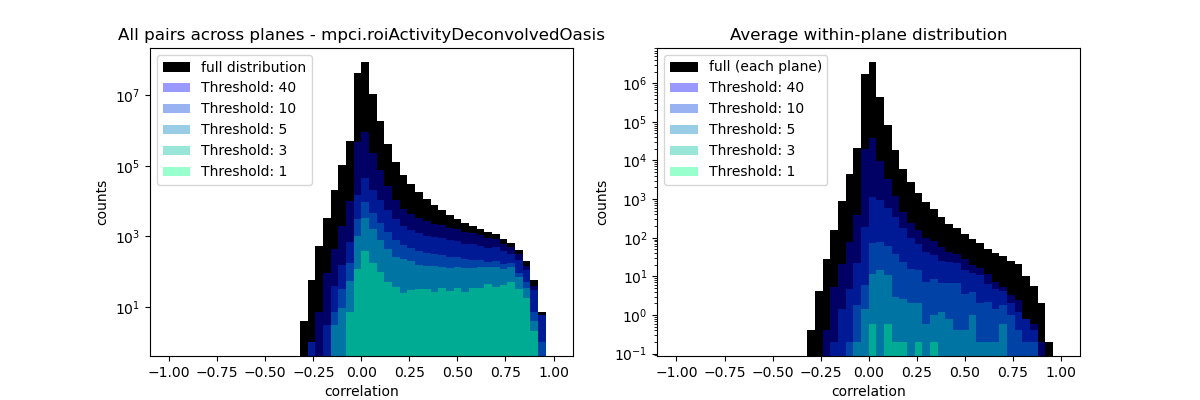

In [11]:
scc = analysis.sameCellCandidates(vrexp,autorun=False)
scc.run(npixCutoff=0)
scc.plotSession();

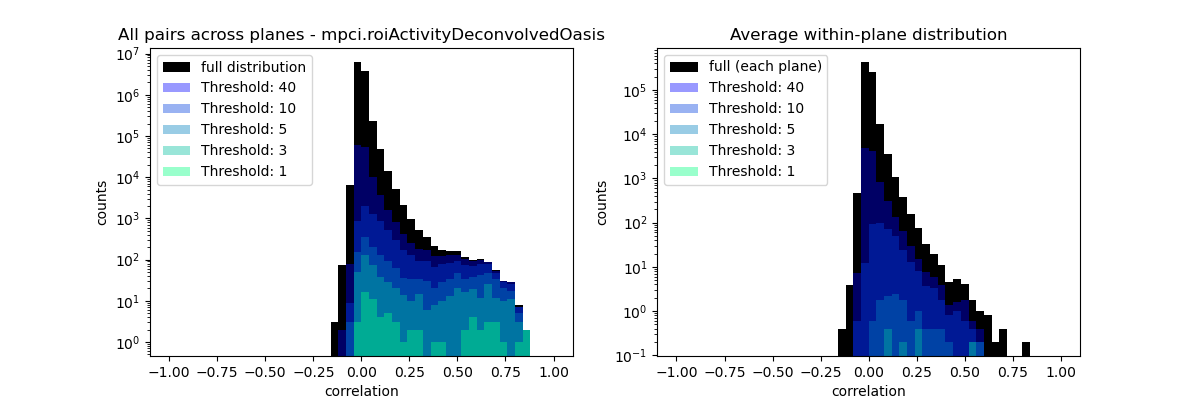

In [43]:
scc = analysis.sameCellCandidates(vrexp,autorun=False)
scc.run(npixCutoff=50)
scc.plotSession();

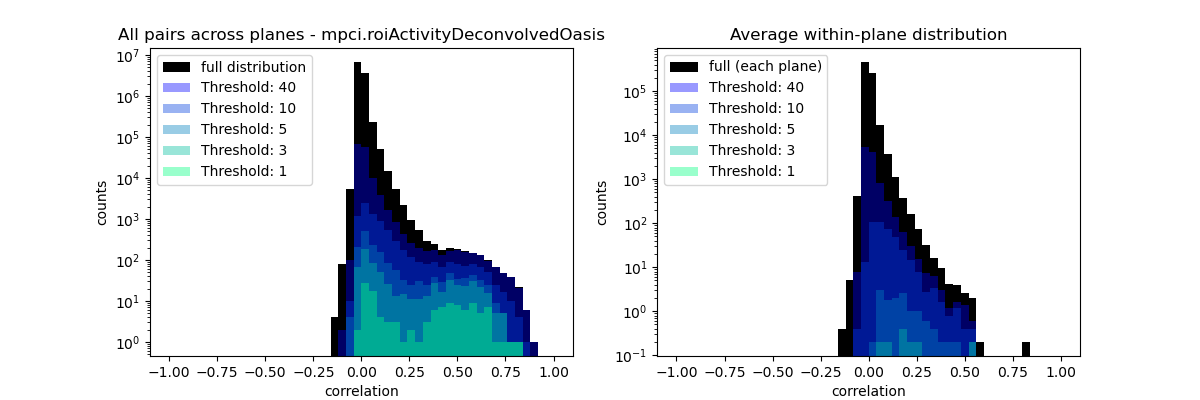

In [12]:
scc = analysis.sameCellCandidates(vrexp,autorun=False)
scc.run(npixCutoff=50, keepPlanes=[0,3,4])
scc.plotSession();

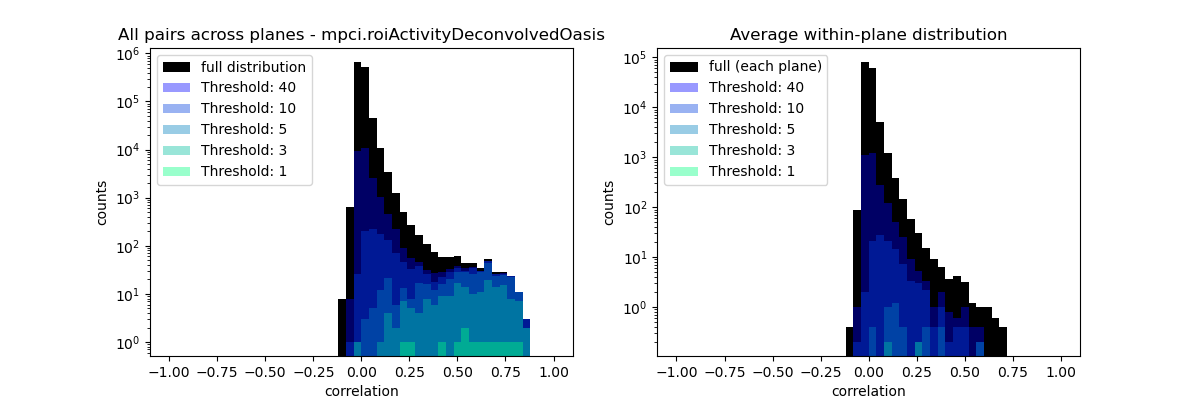

In [13]:
scc = analysis.sameCellCandidates(vrexp,autorun=False)
scc.run(npixCutoff=50, keepPlanes=[1,2])
scc.plotSession();

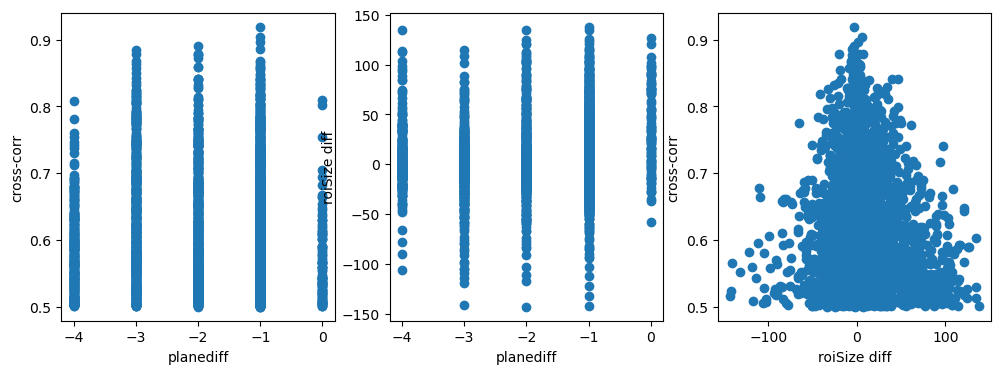

In [208]:
scc = analysis.sameCellCandidates(vrexp, autorun=False)
scc.somaDendritePairs()

Text(0, 0.5, 'counts')

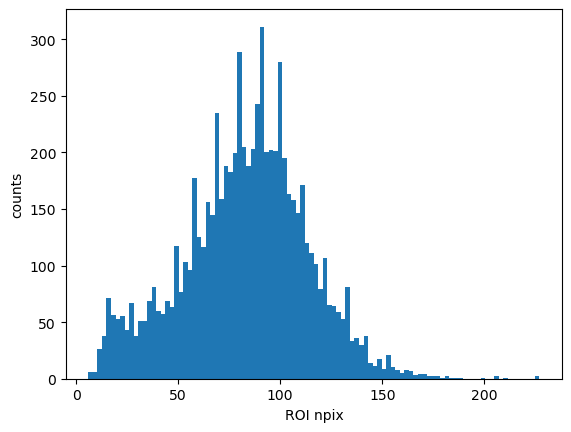

In [216]:
npix = np.array([s['npix'] for s in vrexp.loadS2P('stat')])
plt.hist(npix, bins=100)
plt.xlabel('ROI npix')
plt.ylabel('counts')

In [14]:
# for idx, row in vrdb.getTable(imaging=True, vrRegistration=True).iterrows():
#     plt.close('all')
#     cVrExp = vrdb.vrExperiment(row)
#     scc = vra.sameCellCandidates(cVrExp)
#     scc.plotSession(withSave=True);

In [56]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - show full database -
# - show selected entries (like for example entries with imaging but no suite2p) -
#                --> It would be sweet to make this work where there are some defaults, but then there is also a "filter command" option which you type and goes as the input to the filtering
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update
# - Find way to determine if a suite2p file was updated after the folder was made (indicating that QC was done afterwards) -- so registration should be rerun for imaging data at least
#    -- check if "iscell" is the only thing that was done after registration. In this case, just update the iscell oneData
# ---------------------
# - Add new entry GUI!!!
# ---------------------
# - Check session folders to see if new session is present that isn't registered in the database? 
# ---------------------
# vrExperimentUpdates: 
# -- if edited iscell, will need to re-register the number of ROIs per plane (in "self.values") and reprocess imaging data!
# ---------------------
# vrExperimentRegistration
# -- if error, then note there was an error and append an explanation...!!!
# ---------------------
# I need a readme file for the dbManagement component that shows common uses (e.g. a tutorial)
#    - because otherwise I'll forget what I wrote....
# ---------------------

In [ ]:
# Creating a suite2p classifier
# Let's put a few sessions (all planes) into the classifier by "building" a new classifier
# I'll get at least 2 sessions from each mouse...

# List of QC'd sessions:
# ATL012/2023-01-18/701 Planes 
# ATL028/2023-08-08/701 Planes 1, 2

In [41]:
vrdb.tableData()[0]

['uSessionID',
 'mouseName',
 'sessionDate',
 'sessionID',
 'experimentType',
 'experimentID',
 'variableGain',
 'behavior',
 'imaging',
 'faceCamera',
 'vrEnvironments',
 'headPlateRotation',
 'numPlanes',
 'planeSeparation',
 'pockelsPercentage',
 'objectiveRotation',
 'vrRegistration',
 'suite2p',
 'suite2pQC',
 'redCellQC',
 'sessionQC',
 'scratchJustification',
 'logtime',
 'sessionNotes',
 'suite2pDate',
 'vrRegistrationDate',
 'vrRegistrationError',
 'vrRegistrationException']

In [44]:
vrdb.printSessions(mouseName="ATL027", imaging=True)

ATL027/2023-07-19/701
ATL027/2023-07-20/701
ATL027/2023-07-21/701
ATL027/2023-07-24/701
ATL027/2023-07-25/701
ATL027/2023-07-26/701
ATL027/2023-07-27/701
ATL027/2023-07-28/701
ATL027/2023-08-01/701
ATL027/2023-08-02/701
ATL027/2023-08-04/702
ATL027/2023-08-07/701
ATL027/2023-08-08/701
ATL027/2023-08-09/701


In [40]:
vrdb = database.vrDatabase()

In [9]:
vrdb.registerSessions(maxData=50e9)

In registerSessions, 'vrBehaviorVersion' is an important input that hasn't been coded yet!


In [10]:
for idx, row in vrdb.needsRegistration().iterrows():
    print(vrdb.vrSession(row).sessionPrint())

In [11]:
db = vrdb.getTable(suite2p=True)
for idx, row in db.iterrows():
    print(vrdb.vrSession(row).sessionPrint(), row['suite2pDate'])

ATL012/2023-01-18/701 2023-01-18 14:20:04
ATL012/2023-01-20/701 2023-01-20 11:15:30
ATL012/2023-01-20/702 2023-01-20 13:44:47
ATL012/2023-01-23/701 2023-01-23 13:32:56
ATL012/2023-01-24/703 2023-01-24 11:05:34
ATL012/2023-01-25/701 2023-01-25 10:19:05
ATL012/2023-01-26/702 2023-08-10 09:23:42
ATL012/2023-01-27/701 2023-01-27 12:41:10
ATL012/2023-01-30/702 2023-08-17 17:37:21
ATL012/2023-02-01/701 2023-02-11 18:52:22
ATL012/2023-02-02/701 2023-02-12 09:54:55
ATL012/2023-02-06/701 2023-02-12 14:36:14
ATL012/2023-02-07/701 2023-02-12 17:54:09
ATL012/2023-02-08/702 2023-02-13 14:42:00
ATL012/2023-02-09/701 2023-02-17 13:24:17
ATL012/2023-02-14/703 2023-02-17 14:44:52
ATL012/2023-02-15/701 2023-02-17 18:45:50
ATL012/2023-02-16/701 2023-02-20 11:05:53
ATL012/2023-02-20/701 2023-02-20 16:24:37
ATL012/2023-02-21/702 2023-02-27 09:20:44
ATL012/2023-02-22/701 2023-02-27 10:11:00
ATL012/2023-02-27/701 2023-02-27 14:07:55
ATL012/2023-02-28/701 2023-03-22 11:00:00
ATL012/2023-03-01/701 2023-08-17 2

In [13]:
fm.s2pTargets('ATL022','2023-04-26','701')

\\zaru.cortexlab.net\Subjects\ATL022\2023-04-26\701
C:\Users\andrew\Documents\localData\ATL022\2023-04-26\701


In [74]:
vrdb.printRegistrationErrors()

In [73]:
vrdb.registerSingleSession('ATL022','2023-04-26','701')

Performing vrExperiment preprocessing for session: ATL022/2023-04-26/701
Cleared oneData from session: ATL022/2023-04-26/701
In session: ATL022/2023-04-26/701, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
Performing oasis...


100%|████████████████████████████████████████████████████████████████████████████| 17527/17527 [04:12<00:00, 69.30it/s]


Computing red cell features for ATL022/2023-04-26/701... (usually takes 10-20 seconds)
Facecam preprocessing has not been coded yet!
Saving params...
Session ATL022/2023-04-26/701 registered with 5.74 GB oneData.


True

In [84]:
vrdb.updateSuite2pDateTime()
vrdb.checkS2P(withDatabaseUpdate=True)

In [24]:
session.vrSession('ATL012','2023-01-18','701').sessionPath()

WindowsPath('C:/Users/andrew/Documents/localData/ATL012/2023-01-18/701')

In [16]:
vrdb.printRequiresS2P(needsQC=True)

Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-18/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-20/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-20/702
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-23/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-24/703
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-25/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-26/702
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-27/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-30/702
Database indicates that suite2p has been run but not QC'd: ATL012/2023-02-01/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-02-02/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-02-06/701
Database indicates that suit